In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())   
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8740 - acc: 0.2379
Epoch 00001: val_loss improved from inf to 1.86330, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_6_conv_checkpoint/001-1.8633.hdf5
36805/36805 [==============================] - 176s 5ms/sample - loss: 2.8739 - acc: 0.2379 - val_loss: 1.8633 - val_acc: 0.4309
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0497 - acc: 0.3995
Epoch 00002: val_loss improved from 1.86330 to 1.76672, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_6_conv_checkpoint/002-1.7667.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 2.0498 - acc: 0.3995 - val_loss: 1.7667 - val_acc: 0.4559
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6817 - acc: 0.4952
Epoch 00003: val_loss did not

36800/36805 [============================>.] - ETA: 0s - loss: 0.5476 - acc: 0.8344
Epoch 00027: val_loss did not improve from 0.72419
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.5476 - acc: 0.8344 - val_loss: 1.0956 - val_acc: 0.7177
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5414 - acc: 0.8336
Epoch 00028: val_loss did not improve from 0.72419
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.5414 - acc: 0.8336 - val_loss: 0.9001 - val_acc: 0.7426
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5261 - acc: 0.8396
Epoch 00029: val_loss did not improve from 0.72419
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.5261 - acc: 0.8396 - val_loss: 1.1787 - val_acc: 0.6865
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5191 - acc: 0.8437
Epoch 00030: val_loss did not improve from 0.72419
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3473 - acc: 0.8905
Epoch 00056: val_loss did not improve from 0.70939
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.3472 - acc: 0.8905 - val_loss: 1.2819 - val_acc: 0.7046
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3345 - acc: 0.8919
Epoch 00057: val_loss did not improve from 0.70939
36805/36805 [==============================] - 166s 4ms/sample - loss: 0.3345 - acc: 0.8919 - val_loss: 1.1300 - val_acc: 0.7303
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3346 - acc: 0.8938
Epoch 00058: val_loss did not improve from 0.70939
36805/36805 [==============================] - 166s 4ms/sample - loss: 0.3349 - acc: 0.8937 - val_loss: 1.4805 - val_acc: 0.6434
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3289 - acc: 0.8952
Epoch 00059: val_loss did not improve from 0.70939
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2371 - acc: 0.9227
Epoch 00085: val_loss did not improve from 0.68543
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2372 - acc: 0.9227 - val_loss: 0.7481 - val_acc: 0.8178
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2318 - acc: 0.9254
Epoch 00086: val_loss did not improve from 0.68543
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2318 - acc: 0.9254 - val_loss: 1.6539 - val_acc: 0.6925
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9264
Epoch 00087: val_loss did not improve from 0.68543
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2275 - acc: 0.9263 - val_loss: 1.6868 - val_acc: 0.6629
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2295 - acc: 0.9250
Epoch 00088: val_loss did not improve from 0.68543
36805/36805 [=====================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1578 - acc: 0.9486
Epoch 00115: val_loss did not improve from 0.68543
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1578 - acc: 0.9485 - val_loss: 1.3979 - val_acc: 0.7303
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1673 - acc: 0.9443
Epoch 00116: val_loss did not improve from 0.68543
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1673 - acc: 0.9443 - val_loss: 2.1741 - val_acc: 0.6455

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_6_conv Model


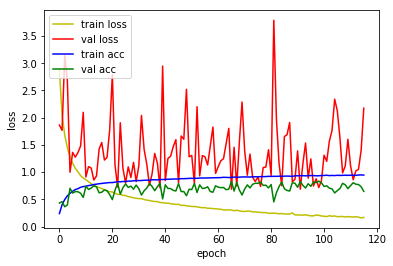

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8138 - acc: 0.7896
Loss: 0.8137692730251007 Accuracy: 0.7896158

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9432 - acc: 0.2148
Epoch 00001: val_loss improved from inf to 1.92318, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/001-1.9232.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 2.9431 - acc: 0.2148 - val_loss: 1.9232 - val_acc: 0.3904
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1049 - acc: 0.3789
Epoch 00002: val_loss improved from 1.92318 to 1.67779, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/002-1.6778.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 2.1049 - acc: 0.3789 - val_loss: 1.6778 - val_acc: 0.4675
Epoch 3/500
36800/36805 [==============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4316 - acc: 0.8724
Epoch 00026: val_loss improved from 0.56173 to 0.48345, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/026-0.4835.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.4317 - acc: 0.8724 - val_loss: 0.4835 - val_acc: 0.8633
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4297 - acc: 0.8744
Epoch 00027: val_loss did not improve from 0.48345
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.4299 - acc: 0.8743 - val_loss: 0.5587 - val_acc: 0.8341
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4158 - acc: 0.8763
Epoch 00028: val_loss improved from 0.48345 to 0.44245, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/028-0.4425.hdf5
36805/36805 [==============================] - 168s 5ms/sample - los

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9331
Epoch 00054: val_loss improved from 0.43320 to 0.41643, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/054-0.4164.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2152 - acc: 0.9331 - val_loss: 0.4164 - val_acc: 0.8873
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2106 - acc: 0.9338
Epoch 00055: val_loss did not improve from 0.41643
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2106 - acc: 0.9338 - val_loss: 1.0515 - val_acc: 0.7577
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2117 - acc: 0.9336
Epoch 00056: val_loss did not improve from 0.41643
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2118 - acc: 0.9336 - val_loss: 0.7341 - val_acc: 0.8169
Epoch 57/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9635
Epoch 00082: val_loss did not improve from 0.38980
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1198 - acc: 0.9635 - val_loss: 0.4302 - val_acc: 0.8901
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9642
Epoch 00083: val_loss did not improve from 0.38980
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1139 - acc: 0.9642 - val_loss: 0.5043 - val_acc: 0.8770
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1273 - acc: 0.9585
Epoch 00084: val_loss did not improve from 0.38980
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1273 - acc: 0.9585 - val_loss: 0.4826 - val_acc: 0.8824
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1171 - acc: 0.9623
Epoch 00085: val_loss improved from 0.38980 to 0.38714, saving model to model/checkpo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9730
Epoch 00111: val_loss did not improve from 0.38714
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0844 - acc: 0.9729 - val_loss: 0.6943 - val_acc: 0.8546
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9643
Epoch 00112: val_loss improved from 0.38714 to 0.35231, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv_checkpoint/112-0.3523.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1137 - acc: 0.9643 - val_loss: 0.3523 - val_acc: 0.9150
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0748 - acc: 0.9764
Epoch 00113: val_loss did not improve from 0.35231
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0748 - acc: 0.9764 - val_loss: 0.4592 - val_acc: 0.8903
Epoch 114/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9821
Epoch 00140: val_loss did not improve from 0.35231
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0561 - acc: 0.9821 - val_loss: 0.8400 - val_acc: 0.8332
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9782
Epoch 00141: val_loss did not improve from 0.35231
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0679 - acc: 0.9782 - val_loss: 0.6172 - val_acc: 0.8693
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9847
Epoch 00142: val_loss did not improve from 0.35231
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0480 - acc: 0.9846 - val_loss: 0.4236 - val_acc: 0.9075
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9759
Epoch 00143: val_loss did not improve from 0.35231
36805/36805 [==================

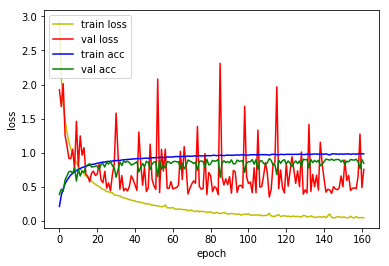

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4646 - acc: 0.8924
Loss: 0.4645967050009675 Accuracy: 0.8924195

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0352 - acc: 0.1896
Epoch 00001: val_loss improved from inf to 2.07625, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_8_conv_checkpoint/001-2.0763.hdf5
36805/36805 [==============================] - 197s 5ms/sample - loss: 3.0353 - acc: 0.1896 - val_loss: 2.0763 - val_acc: 0.3510
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1884 - acc: 0.3474
Epoch 00002: val_loss improved from 2.07625 to 1.75526, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_8_conv_checkpoint/002-1.7553.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 2.1885 - acc: 0.3474 - val_loss: 1.7553 - val_acc: 0.4524
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.3150 - acc: 0.9060
Epoch 00023: val_loss did not improve from 0.37707
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.3150 - acc: 0.9060 - val_loss: 0.7672 - val_acc: 0.7934
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3004 - acc: 0.9104
Epoch 00024: val_loss improved from 0.37707 to 0.35486, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_8_conv_checkpoint/024-0.3549.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.3005 - acc: 0.9104 - val_loss: 0.3549 - val_acc: 0.9003
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2896 - acc: 0.9147
Epoch 00025: val_loss improved from 0.35486 to 0.34835, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_8_conv_checkpoint/025-0.3484.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.2898 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.1388 - acc: 0.9585
Epoch 00050: val_loss improved from 0.23096 to 0.19747, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_8_conv_checkpoint/050-0.1975.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1390 - acc: 0.9584 - val_loss: 0.1975 - val_acc: 0.9427
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1340 - acc: 0.9598
Epoch 00051: val_loss did not improve from 0.19747
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.1340 - acc: 0.9598 - val_loss: 0.2694 - val_acc: 0.9238
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9617
Epoch 00052: val_loss did not improve from 0.19747
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.1250 - acc: 0.9617 - val_loss: 0.2742 - val_acc: 0.9241
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9778
Epoch 00079: val_loss did not improve from 0.19747
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0705 - acc: 0.9778 - val_loss: 0.3629 - val_acc: 0.9047
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9799
Epoch 00080: val_loss did not improve from 0.19747
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0659 - acc: 0.9799 - val_loss: 0.3351 - val_acc: 0.9164
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9804
Epoch 00081: val_loss did not improve from 0.19747
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0628 - acc: 0.9804 - val_loss: 0.3185 - val_acc: 0.9224
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9806
Epoch 00082: val_loss did not improve from 0.19747
36805/36805 [=====================

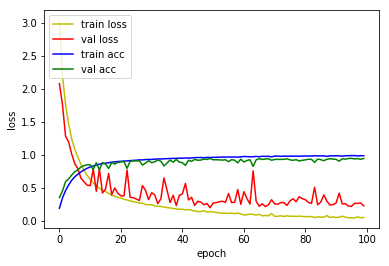

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2594 - acc: 0.9269
Loss: 0.25936675077905785 Accuracy: 0.92689514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7276 - acc: 0.2619
Epoch 00001: val_loss improved from inf to 1.90959, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv_checkpoint/001-1.9096.hdf5
36805/36805 [==============================] - 222s 6ms/sample - loss: 2.7275 - acc: 0.2619 - val_loss: 1.9096 - val_acc: 0.4051
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7707 - acc: 0.4736
Epoch 00002: val_loss improved from 1.90959 to 1.78342, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv_checkpoint/002-1.7834.hdf5
36805/36805 [==============================] - 175s 5ms/sample - loss: 1.7705 - acc: 0.4737 - val_loss: 1.7834 - val_acc: 0.4745
Epoch 3/500
36800/36805 [============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9552
Epoch 00024: val_loss did not improve from 0.20297
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.1489 - acc: 0.9552 - val_loss: 0.2313 - val_acc: 0.9311
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9590
Epoch 00025: val_loss did not improve from 0.20297
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.1376 - acc: 0.9590 - val_loss: 0.2245 - val_acc: 0.9350
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1297 - acc: 0.9615
Epoch 00026: val_loss did not improve from 0.20297
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1297 - acc: 0.9616 - val_loss: 0.2133 - val_acc: 0.9383
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9638
Epoch 00027: val_loss did not improve from 0.20297
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9837
Epoch 00052: val_loss did not improve from 0.17494
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0533 - acc: 0.9837 - val_loss: 0.2842 - val_acc: 0.9322
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9884
Epoch 00053: val_loss improved from 0.17494 to 0.17455, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv_checkpoint/053-0.1745.hdf5
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0365 - acc: 0.9884 - val_loss: 0.1745 - val_acc: 0.9548
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9877
Epoch 00054: val_loss improved from 0.17455 to 0.17144, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv_checkpoint/054-0.1714.hdf5
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0408 - a

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9938
Epoch 00081: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0213 - acc: 0.9938 - val_loss: 0.2236 - val_acc: 0.9534
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9923
Epoch 00082: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0250 - acc: 0.9923 - val_loss: 0.2104 - val_acc: 0.9525
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9929
Epoch 00083: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0243 - acc: 0.9929 - val_loss: 0.1794 - val_acc: 0.9574
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9934
Epoch 00084: val_loss did not improve from 0.16866
36805/36805 [========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9953
Epoch 00111: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0157 - acc: 0.9953 - val_loss: 0.2195 - val_acc: 0.9543
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9937
Epoch 00112: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0206 - acc: 0.9937 - val_loss: 0.2010 - val_acc: 0.9581
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9918
Epoch 00113: val_loss did not improve from 0.16866
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0266 - acc: 0.9918 - val_loss: 0.2233 - val_acc: 0.9536
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9969
Epoch 00114: val_loss did not improve from 0.16866
36805/36805 [====

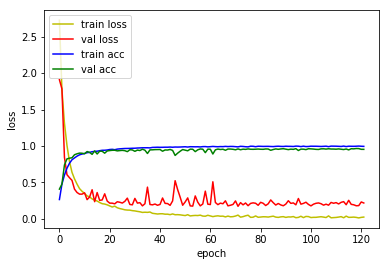

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2445 - acc: 0.9448
Loss: 0.244535535413033 Accuracy: 0.944756



In [10]:
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN'

for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.2439 - acc: 0.7279
Loss: 1.2438688593366312 Accuracy: 0.7279335

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Ac

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.8138 - acc: 0.7896
Loss: 0.8137692730251007 Accuracy: 0.7896158

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_102 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_102 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_103 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_103 (Ac

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2594 - acc: 0.9269
Loss: 0.25936675077905785 Accuracy: 0.92689514

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2445 - acc: 0.9448
Loss: 0.244535535413033 Accuracy: 0.944756


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.5850 - acc: 0.7028
Loss: 1.5850401088332338 Accuracy: 0.70280373

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (A

4815/4815 [==============================] - 10s 2ms/sample - loss: 2.4760 - acc: 0.6353
Loss: 2.4760207142042594 Accuracy: 0.63530636

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_102 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_102 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_103 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_103 (

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2982 - acc: 0.9271
Loss: 0.2982376911552663 Accuracy: 0.9271028

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (A

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2978 - acc: 0.9398
Loss: 0.29782334990753007 Accuracy: 0.93977153
